In [107]:
#!pip install gymnasium

In [108]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np

import os
import glob
import time

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal #dùng cho môi trường liên tục
from torch.distributions import Categorical #Lựa chọn hành động từ phân phối rời rạc.
from torch.utils.data import TensorDataset, DataLoader

In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)   

cpu


PAPER ENVIRONMENT

In [ ]:
class ENV_paper():
    def __init__(self,
                 lambda_rate,
                 D_max,
                 xi,
                 max_power,
                 snr_feedback,
                 harq_type):
        

        # Tham số hệ thống
        self.lambda_rate = lambda_rate  # Tốc độ đến trung bình (bit/slot)
        self.D_max = D_max  # Độ trễ tối đa (slot)
        self.xi = xi  # Xác suất vi phạm độ trễ mục tiêu
        self.max_power = max_power  # Công suất tối đa
        self.snr_feedback = snr_feedback  # Có phản hồi SNR hay không
        self.harq_type = harq_type  # Loại HARQ: 'CC' hoặc 'IR'
        self.n = 200  # Số lần sử dụng kênh mỗi slot
        self.T = int(10 / xi)  # Số slot mỗi episode
        self.Delta = 20 * max_power  # Hằng số phạt lớn
        self.beta = 16  # Số mũ cho hàm phạt


        # Không gian trạng thái
        state_dim = 4 if not snr_feedback else 5
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(state_dim,), dtype=np.float32)


        # Không gian hành động: [R(t), p(t)]
        self.action_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([np.inf, max_power]), dtype=np.float32)

        # Bộ nhớ lịch sử A(t) cho D_max slot gần nhất
        self.arrival_history = []
        self.previous_snrs = []

        # Khởi tạo trạng thái
        self.reset()


    def reset(self):
        #Đặt lại môi trường về trạng thái ban đầu
        self.q_t = 0  # Độ dài hàng đợi
        self.A_t = np.random.poisson(self.lambda_rate)  # Số bit đến
        self.d_t = 0  # Số lần vi phạm độ trễ trong episode
        self.k = 0  # Số lần truyền của gói tin hiện tại
        self.t = 0  # đếm bước hiện tại
        self.gamma_k = 0 if self.snr_feedback else None  # SNR còn lại
        self.arrival_history = [self.A_t]
        self.previous_snrs = []
        state = [self.q_t, self.A_t, self.d_t, self.k]
        if self.snr_feedback:
            state.append(self.gamma_k)
        return np.array(state)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                



    def step(self, action):
        R_t, p_t = action  # Tốc độ mã hóa và công suất truyền
        self.t += 1


        R_t = max(R_t, 0)
        p_t = np.clip(p_t, 0, self.max_power)




        # Mô phỏng kênh fading Rayleigh
        #h = (np.random.normal(0, 1) + 1j * np.random.normal(0, 1)) / np.sqrt(2)

        h = np.exp(-0.151 * np.random.uniform(0.5, 1) * 8 )

        # rho = 0.7
        # sigma_CSI = 1
        # eps = np.random.normal(0, sigma_CSI)
        # h_est = rho * h + np.sqrt(1 - rho**2) * eps

        # snr = p_t * (np.abs(h_est)**2)
        snr = p_t * (np.abs(h)**2)



        # Xác định thành công truyền
        if self.k == 0:  # Truyền mới
            success = np.log2(1 + snr) >= R_t
        else:  # Truyền lại
            if self.harq_type == 'CC':
                if self.snr_feedback:
                    accumulated_snr = sum(self.previous_snrs) + snr
                    success = np.log2(1 + accumulated_snr) >= R_t
                else:
                    # Giả định công suất không đổi qua các lần truyền lại
                    # Cần xem lại vì mỗi lần truyền lại p_t không đổi nhưng có h khác nhau
                    accumulated_snr = sum(self.previous_snrs) + snr
                    success = np.log2(1 + accumulated_snr) >= R_t
            elif self.harq_type == 'IR':
                if self.snr_feedback:
                    total_rate = sum([np.log2(1 + s) for s in self.previous_snrs]) + np.log2(1 + snr)
                    success = total_rate >= R_t
        

        
        # Tính toán tốc độ phục vụ S(t)
        S_t = self.n * R_t if success else 0

        # Cập nhật độ dài hàng đợi tạm thời
        q_tmp = max(self.q_t + self.A_t - S_t, 0)


        
        # Tính q_th(t) dựa trên lịch sử A(t) trong D_max slot
        if len(self.arrival_history) >= self.D_max:
            q_th = sum(self.arrival_history[-self.D_max:])
        else:
            q_th = sum(self.arrival_history)
        
        # Kiểm tra vi phạm độ trễ
        if q_tmp > q_th:
            self.d_t += 1
            w_t = self._calculate_penalty()
            reward = -p_t - w_t
        else:
            reward = -p_t
        
        # Cập nhật hàng đợi với PODD
        self.q_t = min(q_tmp, q_th)



        # Cập nhật trạng thái
        self.A_t = np.random.poisson(self.lambda_rate)
        self.arrival_history.append(self.A_t)
        if len(self.arrival_history) > self.D_max:
            self.arrival_history.pop(0)
        
        if success:
            self.k = 0
            self.gamma_k = 0 if self.snr_feedback else None
            self.previous_snrs = []
        else:
            self.k += 1
            self.previous_snrs.append(snr)
            if self.snr_feedback:
                if self.harq_type == 'CC':
                    self.gamma_k = max(2**R_t - 1 - sum(self.previous_snrs), 0)
                elif self.harq_type == 'IR':
                    self.gamma_k = max((2**R_t) / np.prod([1 + s for s in self.previous_snrs]) - 1, 0)
        
        state = [self.q_t, self.A_t, self.d_t, self.k]
        if self.snr_feedback:
            state.append(self.gamma_k)
        
        # Kiểm tra kết thúc episode (giả định đơn giản)
        done = self.t >= self.T
        
        info = {'power': p_t, 'delay_violation': self.d_t, 'Rate': R_t}
        
        return np.array(state), reward, done, info
    




    def _calculate_penalty(self):
        #Tính toán giá trị phạt w(t) dựa trên số lần vi phạm độ trễ.
        if self.d_t <= self.T * self.xi:
            return self.Delta * (self.d_t / (self.T * self.xi)) ** self.beta
        return self.Delta
    

    

Tạo RolloutBuffer, lưu data lại để train, tạo hàm để update lúc train.

In [111]:
#RolloutBuffer Bộ nhớ tạm lưu giữ thông tin huấn luyện sau
#lưu trữ tạm thời các quỹ đạo 
#tập hợp dữ liệu về các tương tác của tác nhân (agent) với môi trường trong một tập hợp (episode), tính hàm lợi thế

class RolloutBuffer:
    def __init__(self):
        self.actions = [] #Lưu các hành động đã thực hiện
        self.states = []  #Lưu các trạng thái hiện tại
        self.logprobs = []#Lưu log của xác suất pi(a|s)
        self.rewards = [] #Lưu lại reward
        self.state_values = [] # Giá trị trạng thái V do critic dự đoán, để tính hàm lợi thế
        self.is_terminals = [] #Lưu lại cờ kết thúc


    def clear(self): #xóa buffer để update data mới
        del self.actions[:] 
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


#Actor: Mạng chính sách, xuất ra phân phối xác suất dựa trên trạng thái
#Critic: Mạng giá trị, Ước lượng giá trị trạng thái (Vt) để tính hàm ưu tiên
#hàm này giúp Agent chọn lọc hành động, đánh giá được trạng thái.
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std = None):
        #state_dim: Số chiều của state
        #action_dim: số chiều của action
        #xem action có liên tục không
        #action_std_init: độ lệch chuẩn cho phân phối liên tục
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space

        #Nếu hành động liên tục lưu lại chiều hành động chuyển đến phương sai action_std_init^2

        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std * action_std).to(device)

        # ACTOR
        if has_continuous_action_space : # continuous action space
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 128),
                            nn.Tanh(),
                            nn.Linear(128, 128),
                            nn.Tanh(),
                            nn.Linear(128, action_dim),
                            #nn.Tanh()
        #Nếu là hành động liên tục thì đầu ra là trung bình u(s) phân phối Gauss => phân phối hành động π(a|s) = N(u,tổng)
        #Tanh giới hạn đầu ra từ [-1,1], phù hợp vs phạm v hành động
                        )
        else: # discrete action space
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 128),
                            nn.Tanh(),
                            nn.Linear(128, 128),
                            nn.Tanh(),
                            nn.Linear(128, action_dim),
                            nn.Softmax(dim=-1)
                        )
        #Không gian rời rạc: xuất ra xác suất cho từng action rời rạc theo Softmax

        # CRITIC
        # Tương tự như actor nhưng xuất ra là 1 giá trị đơn ước lượng giá trị trạng thái Vt
        # Dùng để tính hàm lợi thế At = Q(s,a) - Vt
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 128),
                        nn.Tanh(),
                        nn.Linear(128, 128),
                        nn.Tanh(),
                        nn.Linear(128, 1)
                    )
        
    #Cập nhật phương sai cho hành động liên tục
    #tức là điều chỉnh khám phá, độ biến động cho các action
    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")


    def forward(self):
        raise NotImplementedError


    
    def act(self, state): #đầu vào là state hiện tại

        # ACTOR
        if self.has_continuous_action_space:
            action_mean = self.actor(state) #Nếu đầu vào là state liên tục thì đầu ra actor là giá trị trung bình u phân phối gauss
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0) #phương sai Cov
            dist = MultivariateNormal(action_mean, cov_mat) #tạo phân phối đa biến
        else:
            action_probs = self.actor(state) #đầu ra softmax
            dist = Categorical(action_probs) #phân phối rời rạc

        action = dist.sample() #chọn hành động bằng cách lấy mẫu phân phối 
        action_logprob = dist.log_prob(action) #lấy log của các suất được chọn (π(a|s))

        # CRITIC
        state_val = self.critic(state) #xuất ra giá Vt từ critic

        return action.detach(), action_logprob.detach(), state_val.detach() #trả về action, log, Vt để lưu vào RolloutBuffer

    #Dùng để tính toán lại các giá trị cần thiết khi cập nhật danh sách:
        #+Log xác suất hành động 
        #+Entropy của chính sách
        #+Ước lượng giá trị trạng thái Vt
    # Đầu vào là state, action cũ đầu ra là logprob (mới), value (mới), entropy
    # So sánh policy cũ và mới.
    def evaluate(self, state, action):

        # ACTOR
        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # for single action continuous environments
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)

        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()

        # CRITIC
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy 
# Tại sao có act rồi cần dùng evaluate:
#    + act dùng để action và thu thập dữ liệu xong lưu vào RolloutBuffer để train
#    + evaluate dùng để tính toán train, policy cũ và mới: ratio, advantage, entropy.
# act → buffer → evaluate → loss → update.

In [112]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, lambda_gae, K_epochs, eps_clip, has_continuous_action_space, action_std, minibatch_size=200):
        self.has_continuous_action_space = has_continuous_action_space
        if has_continuous_action_space:
            self.action_std = action_std
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.lambda_gae = lambda_gae
        self.minibatch_size = minibatch_size  # Thêm minibatch_size

        self.buffer = RolloutBuffer()
        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std).to(device)
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)
        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        print("--------------------------------------------------------------------------------------------")

    def select_action(self, state):
        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)
            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)
            return action.item()

    def update(self):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)
        is_terminals = torch.tensor(self.buffer.is_terminals, dtype=torch.float32).to(device)

        # Compute advantages using GAE
        advantages = torch.zeros_like(rewards).to(device)
        gae = 0
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = 0  # No next state value at the end
            else:
                next_value = old_state_values[t + 1] * (1 - is_terminals[t + 1])
            delta = rewards[t] + self.gamma * next_value - old_state_values[t]
            gae = delta + self.gamma * self.lambda_gae * (1 - is_terminals[t]) * gae
            advantages[t] = gae

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-7)

        # Create TensorDataset and DataLoader
        dataset = TensorDataset(old_states, old_actions, old_logprobs, rewards, advantages)
        dataloader = DataLoader(dataset, batch_size=self.minibatch_size, shuffle=True, drop_last=True)

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            for batch in dataloader:
                batch_states, batch_actions, batch_logprobs, batch_rewards, batch_advantages = batch
                logprobs, state_values, dist_entropy = self.policy.evaluate(batch_states, batch_actions)
                state_values = torch.squeeze(state_values)
                ratios = torch.exp(logprobs - batch_logprobs.detach())
                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * batch_advantages
                loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, batch_rewards) - 0.01 * dist_entropy
                self.optimizer.zero_grad()
                loss.mean().backward()
                self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [ ]:
################################### Training ###################################


####### initialize environment hyperparameters ######

has_continuous_action_space = True #không gian action rời rạc
best_reward = -float('inf')  # ban đầu là âm vô cực
max_ep_len = 1000                    # max timesteps in one episode
max_training_timesteps = int(6000000)   # break training loop if timeteps > max_training_timesteps -- dừng train khi số bước vượt quá

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)


action_std = 0.5
action_std_decay_rate = 0.005
min_action_std = 0.1
action_std_decay_freq = 60000

################ PPO hyperparameters ################

update_timestep = 2048    # update policy every n timesteps -- cập nhật policy
K_epochs = 80               # update policy for K epochs -- số lần lặp tối ưu trên 1 batch dữ liệu
eps_clip = 0.2              # clip parameter for PPO 
gamma = 0.99                # discount factor
lambda_gae = 0
lr_actor = 0.0002       # learning rate for actor network
lr_critic = 0.0002       # learning rate for critic network


#####################################################

################## Environment parameters ##############
lambda_rate = 150
D_max = 5
xi = 0.01
max_power = - (2 ** (lambda_rate/200)-1)/(math.log10(1-(xi**(D_max**-1)/D_max)))
snr_feedback=True,# Có phản hồi SNR
harq_type='IR'

env = ENV_paper(lambda_rate, D_max, xi, max_power, snr_feedback, harq_type)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

# print("save checkpoint path : " + checkpoint_path)

#####################################################


############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps")
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

#####################################################

print("============================================================================================")

################# training procedure ################

# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma,lambda_gae, K_epochs, eps_clip, has_continuous_action_space, action_std, minibatch_size = 128)


# printing and logging variables
# print_running_reward = 0
# print_running_episodes = 0

# log_running_reward = 0
# log_running_episodes = 0

time_step = 0
i_episode = 0


# training loop
while time_step <= max_training_timesteps: #vòng lặp dừng khi vượt quá max_time_step

    state = env.reset() #trả về trạng thái ban đầu 

    # Check if state is tuple
    if isinstance(state, tuple):
            state = state[0]

    current_ep_reward = 0 #tổng phần thưởng trong episode hiện tại

    for t in range(1, max_ep_len+1): #chạy tối đa 500 bước

        # select action with policy
        action = ppo_agent.select_action(state) #chọn action cho state dự vào policy hiện tại
        state, reward, done, info = env.step(action) #thực hiện hành động và nhận phản hồi

        # saving reward and is_terminals vào buffer
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done 
        )

        time_step +=1
        current_ep_reward += reward
        #print(info)

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update() #cập nhật lại policy nếu đủ số bước

        # if continuous action space; then decay action std of ouput action distribution
        # Nếu không gian hành động là liên tục, giảm độ lệch chuẩn để chuyển từ khám phá sang khai thác


        # break; if the episode is over
        if done:
            break
    if has_continuous_action_space and time_step % action_std_decay_freq == 0:
        ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)
    print('Episode ', i_episode, ': Reward = ', current_ep_reward)

    # print_running_reward += current_ep_reward
    # print_running_episodes += 1

    # log_running_reward += current_ep_reward
    # log_running_episodes += 1
    # Save model if reward improves
    
    if current_ep_reward >= best_reward and i_episode >=2000:
        print(f"Saving better model at episode {i_episode} with reward {current_ep_reward}")
        best_reward = current_ep_reward
        torch.save(ppo_agent.policy.state_dict(), '200_ppo_best_model_paper.pth')

    i_episode += 1



--------------------------------------------------------------------------------------------
max training timesteps :  6000000
max timesteps per episode :  1000
log frequency : 2000 timesteps
printing average reward over episodes in last : 4000 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  5
action space dimension :  2
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
starting std of action distribution :  0.5
decay rate of std of action distribution :  0.005
minimum std of action distribution :  0.1
decay frequency of std of action distribution : 60000 timesteps
--------------------------------------------------------------------------------------------
PPO update frequency : 2048 timesteps
PPO K epochs :  80
PPO epsilon clip

In [114]:
import torch
import numpy as np

def evaluate_model(ppo_agent, model_path, env, num_episodes=50, max_ep_len=1000):
    """
    Function to evaluate the PPO model over multiple episodes and calculate average results.
    
    Args:
        ppo_agent (PPO): The initialized PPO agent.
        model_path (str): Path to the saved model file.
        env (gym.Env): The environment to evaluate.
        num_episodes (int): Number of episodes to evaluate (default is 50).
        max_ep_len (int): Maximum number of steps per episode (default is 1000).
    
    Returns:
        None
    """
    # Load the saved model state into the policy
    ppo_agent.policy.load_state_dict(torch.load(model_path))
    ppo_agent.policy.eval()

    total_powers = []
    total_rewards = []
    total_delay_violations = []

    for episode in range(1, num_episodes + 1):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        episode_power = 0.0
        episode_reward = 0.0
        delay_violation = 0

        for t in range(1, max_ep_len + 1):
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).to(device)
            
            # Get the mean action from the actor
            with torch.no_grad():
                action_mean = ppo_agent.policy.actor(state_tensor)
            
            # Convert to numpy array for the environment
            action = action_mean.cpu().numpy()
            
            # Perform the action in the environment
            next_state, reward, done, info = env.step(action)
            state = next_state

            # Get information from info
            power = info.get('power', 0.0)
            delay_violation = info.get('delay_violation', 0)
            rate = info.get('Rate')
            
            # Accumulate power and reward
            episode_power += power
            episode_reward += reward

            # Print information for each step
            print(f"Episode {episode}, Step {t}: Power = {power:.2f}, Rate {rate} Delay Violations (dt) = {delay_violation}, Reward = {reward:.2f}")

            if done:
                break

        # Calculate average power for the episode
        average_power = episode_power / t if t > 0 else 0.0

        # Store results of the episode
        total_powers.append(episode_power)
        total_rewards.append(episode_reward)
        total_delay_violations.append(delay_violation)

        # # Print summary for the episode
        # print(f"\n--- Summary of Episode {episode} ---")
        # print(f"Total transmitted power: {episode_power:.2f}")
        # print(f"Average power: {average_power:.2f}")
        # print(f"Total delay violations: {delay_violation}")
        # print(f"Total Reward: {episode_reward:.2f}\n")

    # Calculate average results after 50 episodes
    avg_total_power = np.mean(total_powers)
    avg_average_power = np.mean([power / max_ep_len for power in total_powers])
    avg_total_reward = np.mean(total_rewards)
    avg_delay_violations = np.mean(total_delay_violations)

    print("\n--- Average results after 50 episodes ---")
    print(f"Average total transmitted power: {avg_total_power:.2f}")
    print(f"Average power per episode: {avg_average_power:.2f}")
    print(f"Average total Reward: {avg_total_reward:.2f}")
    print(f"Average number of delay violations: {avg_delay_violations:.2f}")

In [115]:
model_path = '200_ppo_best_model_paper.pth'
evaluate_model(ppo_agent, model_path, env)

Episode 1, Step 1: Power = 0.72, Rate 1.2371249198913574 Delay Violations (dt) = 0, Reward = -0.72
Episode 1, Step 2: Power = 0.81, Rate 0 Delay Violations (dt) = 0, Reward = -0.81
Episode 1, Step 3: Power = 1.81, Rate 0.825564444065094 Delay Violations (dt) = 0, Reward = -1.81
Episode 1, Step 4: Power = 4.33, Rate 2.901477813720703 Delay Violations (dt) = 0, Reward = -4.33
Episode 1, Step 5: Power = 4.16, Rate 2.9969286918640137 Delay Violations (dt) = 0, Reward = -4.16
Episode 1, Step 6: Power = 1.50, Rate 0 Delay Violations (dt) = 0, Reward = -1.50
Episode 1, Step 7: Power = 4.18, Rate 3.014251470565796 Delay Violations (dt) = 0, Reward = -4.18
Episode 1, Step 8: Power = 4.52, Rate 3.2017526626586914 Delay Violations (dt) = 0, Reward = -4.52
Episode 1, Step 9: Power = 4.61, Rate 3.3094677925109863 Delay Violations (dt) = 0, Reward = -4.61
Episode 1, Step 10: Power = 4.74, Rate 2.7188453674316406 Delay Violations (dt) = 0, Reward = -4.74
Episode 1, Step 11: Power = 4.52, Rate 3.20175

In [116]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_single_episode(ppo_agent, model_path, env, max_ep_len=1000):
    # Load the saved model state into the policy
    ppo_agent.policy.load_state_dict(torch.load(model_path))
    ppo_agent.policy.eval()

    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]

    dt_values = []

    for t in range(1, max_ep_len + 1):
        state_tensor = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            action_mean = ppo_agent.policy.actor(state_tensor)
        action = action_mean.cpu().numpy()
        next_state, reward, done, info = env.step(action)
        state = next_state

        delay_violation = info.get('delay_violation', 0)
        dt_values.append(delay_violation)

        print(f"Step {t}: Delay Violations (dt) = {delay_violation}")

        if done:
            break

    # Chỉ lấy các điểm mỗi 10 bước để vẽ
    step_indices = list(range(0, 1001, 50))  # 9, 19, 29,... (từ step 10)
    dt_plot = [dt_values[i] if i < len(dt_values) else dt_values[-1] for i in step_indices]

    plt.figure(figsize=(10, 5))
    plt.plot([i+1 for i in step_indices], dt_plot, marker='o', linestyle='-', color='b')
    plt.xlabel('Time slots')
    plt.ylabel('The cumulative number of delay  violation events')
    #plt.title('Delay Violations per 10 Steps in 1 Episode')
    plt.grid(True)
    plt.yticks(np.arange(min(dt_plot), max(dt_plot)+1, 1))  # bước nhảy trục tung là 1
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    plt.show()
    return dt_plot

Step 1: Delay Violations (dt) = 0
Step 2: Delay Violations (dt) = 0
Step 3: Delay Violations (dt) = 0
Step 4: Delay Violations (dt) = 0
Step 5: Delay Violations (dt) = 0
Step 6: Delay Violations (dt) = 0
Step 7: Delay Violations (dt) = 0
Step 8: Delay Violations (dt) = 0
Step 9: Delay Violations (dt) = 0
Step 10: Delay Violations (dt) = 0
Step 11: Delay Violations (dt) = 0
Step 12: Delay Violations (dt) = 0
Step 13: Delay Violations (dt) = 0
Step 14: Delay Violations (dt) = 0
Step 15: Delay Violations (dt) = 0
Step 16: Delay Violations (dt) = 0
Step 17: Delay Violations (dt) = 0
Step 18: Delay Violations (dt) = 0
Step 19: Delay Violations (dt) = 0
Step 20: Delay Violations (dt) = 0
Step 21: Delay Violations (dt) = 0
Step 22: Delay Violations (dt) = 0
Step 23: Delay Violations (dt) = 0
Step 24: Delay Violations (dt) = 0
Step 25: Delay Violations (dt) = 0
Step 26: Delay Violations (dt) = 0
Step 27: Delay Violations (dt) = 0
Step 28: Delay Violations (dt) = 0
Step 29: Delay Violations (dt

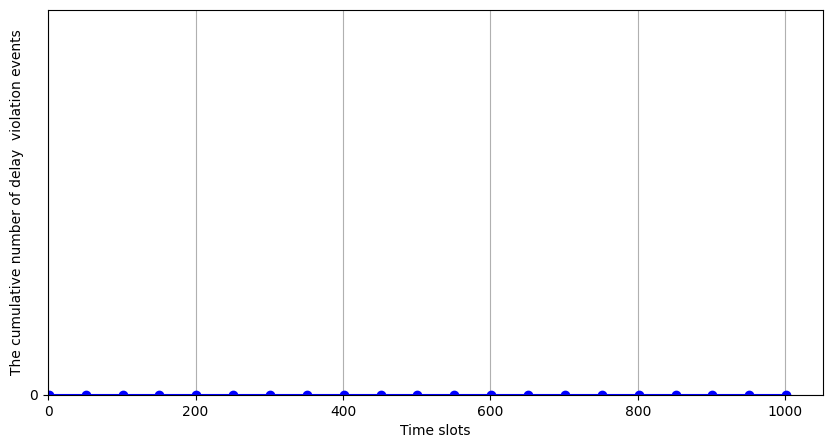

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [117]:
model_path = '200_ppo_best_model_paper.pth'
dt_values = evaluate_single_episode(ppo_agent, model_path, env)
print(dt_values)

In [118]:
def evaluate_single_episode(ppo_agent, model_path, env, max_ep_len=1000):
    # Load the saved model state into the policy
    ppo_agent.policy.load_state_dict(torch.load(model_path))
    ppo_agent.policy.eval()

    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]

    dt_values = []
    power_values = []

    for t in range(1, max_ep_len + 1):
        state_tensor = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            action_mean = ppo_agent.policy.actor(state_tensor)
        action = action_mean.cpu().numpy()
        next_state, reward, done, info = env.step(action)
        state = next_state

        delay_violation = info.get('delay_violation', 0)
        dt_values.append(delay_violation)
        power = info.get('power', 0.0)
        power_values.append(power)

        print(f"Step {t}: Power = {power:.2f}, Delay Violations (dt) = {delay_violation}")

        if done:
            break

    # Tính trung bình công suất mỗi 50 bước
    avg_power_per_50 = []
    for i in range(0, len(power_values), 50):
        avg = np.mean(power_values[i:i+50])
        avg_power_per_50.append(avg)
        print(f"Average power from step {i+1} to {min(i+50, len(power_values))}: {avg:.2f}")

    # Vẽ biểu đồ nếu muốn
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    avg_power_per_50_db = 10 * np.log10(avg_power_per_50)

    plt.plot([i*50+1 for i in range(len(avg_power_per_50_db))], avg_power_per_50_db, marker='o', linestyle='-', color='r')
    plt.xlabel('Time slot')
    plt.ylabel('Average transmit power (dB)')
    plt.grid(True)
    plt.xlim(0, 1000)
    #plt.ylim(0, 7)
    plt.show()
    return avg_power_per_50

Step 1: Power = 0.72, Delay Violations (dt) = 0
Step 2: Power = 0.66, Delay Violations (dt) = 0
Step 3: Power = 1.81, Delay Violations (dt) = 0
Step 4: Power = 4.48, Delay Violations (dt) = 0
Step 5: Power = 4.52, Delay Violations (dt) = 0
Step 6: Power = 1.80, Delay Violations (dt) = 0
Step 7: Power = 4.49, Delay Violations (dt) = 0
Step 8: Power = 4.16, Delay Violations (dt) = 0
Step 9: Power = 1.50, Delay Violations (dt) = 0
Step 10: Power = 4.17, Delay Violations (dt) = 0
Step 11: Power = 4.52, Delay Violations (dt) = 0
Step 12: Power = 3.57, Delay Violations (dt) = 0
Step 13: Power = 4.18, Delay Violations (dt) = 0
Step 14: Power = 0.36, Delay Violations (dt) = 0
Step 15: Power = 4.40, Delay Violations (dt) = 0
Step 16: Power = 4.52, Delay Violations (dt) = 0
Step 17: Power = 4.40, Delay Violations (dt) = 0
Step 18: Power = 4.16, Delay Violations (dt) = 0
Step 19: Power = 1.81, Delay Violations (dt) = 0
Step 20: Power = 4.43, Delay Violations (dt) = 0
Step 21: Power = 4.52, Delay 

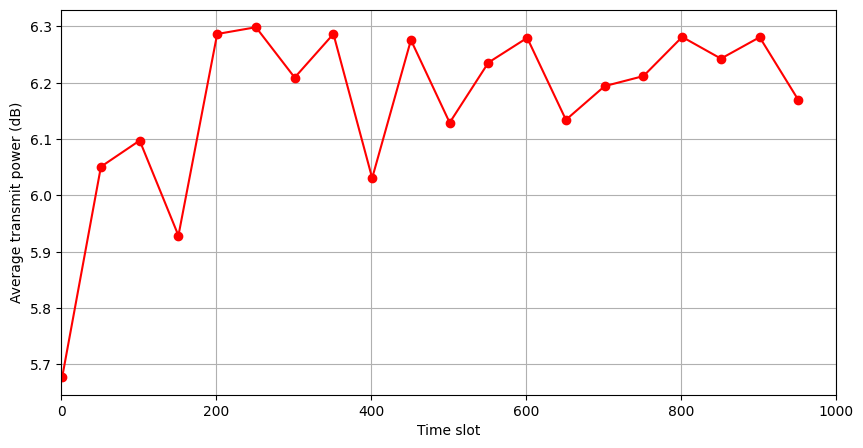

[np.float32(3.6959074),
 np.float32(4.0280232),
 np.float32(4.0713487),
 np.float32(3.916168),
 np.float32(4.2525682),
 np.float32(4.2643766),
 np.float32(4.177515),
 np.float32(4.2526393),
 np.float32(4.0093207),
 np.float32(4.242113),
 np.float32(4.101202),
 np.float32(4.2032495),
 np.float32(4.245888),
 np.float32(4.105996),
 np.float32(4.1629376),
 np.float32(4.1800594),
 np.float32(4.247458),
 np.float32(4.2099743),
 np.float32(4.2470064),
 np.float32(4.1391444)]

In [119]:
model_path = '200_ppo_best_model_paper.pth'
evaluate_single_episode(ppo_agent, model_path, env)

In [120]:
import numpy as np

# Đặt giá trị sigma_CSI_i (ví dụ: 1.0)
sigma_csi_i = 1.0  # Độ lệch chuẩn = sqrt(phương sai)


epsilon_array = np.random.normal(0, sigma_csi_i, size=10000)
print("Trung bình:", np.mean(epsilon_array))  # ~0
print("Phương sai:", np.var(epsilon_array))   # ~sigma_csi_i^2

Trung bình: -0.005614866277630539
Phương sai: 1.0062064470413346
